In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

In [2]:
from keras import backend as K
import keras.layers as layers
from keras.models import Model
from keras import Sequential
from keras.layers import Lambda, Dense, Flatten
from sklearn.metrics import roc_curve, roc_auc_score
from keras.losses import binary_crossentropy
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras import layers
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.
/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/bpnachma

In [3]:
N = 2000000
rho = 0.8

Z0 = np.random.normal(0.,1.5,N)
Z1 = np.random.normal(0.,1.5,N)
Z2 = np.random.normal(0.,1.5,N)
X0 = Z1*rho + Z0*(1.-rho**2)**0.5
X1 = Z1
X2 = Z2

background_x = np.array(tuple(zip(X0, X1, X2)))
background_y = np.zeros(len(background_x))

Z0 = np.random.normal(2.5,1.5,N)
Z1 = np.random.normal(2.5,1.5,N)
Z2 = np.random.normal(2,1.5,N)
signal_x = np.array(tuple(zip(Z0, Z1, Z2)))
signal_y = np.ones(len(signal_x))

X = np.concatenate([background_x,signal_x])
Y = np.concatenate([background_y,signal_y])

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.15)

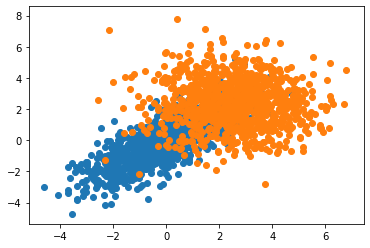

In [4]:
plt.scatter(background_x[:,0][0:1000],background_x[:,1][0:1000])
plt.scatter(signal_x[:,0][0:1000],signal_x[:,1][0:1000])

In [5]:
model_baseline = Sequential()
model_baseline.add(Dense(128, activation='relu',input_shape =(2,))) 
model_baseline.add(Dense(128, activation='relu'))
model_baseline.add(Dense(128, activation='relu'))
model_baseline.add(Dense(1, activation='sigmoid'))
model_baseline.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])
hist_model_baseline = model_baseline.fit(X_train[:,1:3], Y_train, epochs=20, batch_size=int(0.01*len(X_train)),validation_data=(X_val[:,1:3], Y_val))

Train on 3400000 samples, validate on 600000 samples
Epoch 1/20
3400000/3400000 [==============================] - 5s 1us/step - loss: 0.3747 - acc: 0.8342 - val_loss: 0.3264 - val_acc: 0.8570
Epoch 2/20
3400000/3400000 [==============================] - 2s 1us/step - loss: 0.3272 - acc: 0.8568 - val_loss: 0.3259 - val_acc: 0.8572
Epoch 3/20
3400000/3400000 [==============================] - 2s 1us/step - loss: 0.3271 - acc: 0.8568 - val_loss: 0.3259 - val_acc: 0.8571
Epoch 4/20
3400000/3400000 [==============================] - 2s 1us/step - loss: 0.3271 - acc: 0.8568 - val_loss: 0.3259 - val_acc: 0.8572
Epoch 5/20
3400000/3400000 [==============================] - 2s 1us/step - loss: 0.3271 - acc: 0.8568 - val_loss: 0.3259 - val_acc: 0.8573
Epoch 6/20
3400000/3400000 [==============================] - 2s 1us/step - loss: 0.3270 - acc: 0.8569 - val_loss: 0.3261 - val_acc: 0.8572
Epoch 7/20
3400000/3400000 [==============================] - 2s 1us/step - loss: 0.3271 - acc: 0.8568 - va

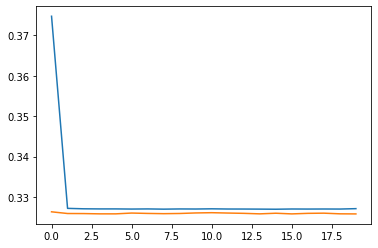

In [6]:
plt.plot(hist_model_baseline.history['loss'])
plt.plot(hist_model_baseline.history['val_loss'])

In [7]:
preds_baseline = model_baseline.predict(X_val[:,1:3])

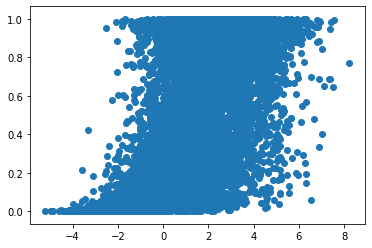

In [8]:
plt.scatter(X_val[:,0][0:10000],preds_baseline[0:10000])

In [9]:
def DisCo_np(X,Y):
    ajk = np.abs(np.reshape(np.repeat(X,len(X)),[len(X),len(X)]) - np.transpose(X))
    bjk = np.abs(np.reshape(np.repeat(Y,len(Y)),[len(Y),len(Y)]) - np.transpose(Y))

    Ajk = ajk - np.mean(ajk,axis=0)[None, :] - np.mean(ajk,axis=1)[:, None] + np.mean(ajk)
    Bjk = bjk - np.mean(bjk,axis=0)[None, :] - np.mean(bjk,axis=1)[:, None] + np.mean(bjk)

    dcor = np.sum(Ajk*Bjk) / np.sqrt(np.sum(Ajk*Ajk)*np.sum(Bjk*Bjk))
    return dcor

In [10]:
DisCo_np(X_val[:,0][0:10000],preds_baseline[0:10000])

0.39302018785637616

In [11]:
def DisCo(y_true, y_pred, x_in, alpha = 0.):
    #alpha determines the amount of decorrelation; 0 means no decorrelation.
    #Note that the decorrelating feature is also used for learning.
    
    X_in = tf.gather(x_in, [0], axis=1) #decorrelate with the first element of the input
    Y_in = y_pred

    #Only require decorrelation for the background.
    mymaskX = tf.where(y_true[:,0]<1,K.ones_like(X_in),K.zeros_like(X_in))
    mymaskY = tf.where(y_true[:,0]<1,K.ones_like(Y_in),K.zeros_like(Y_in))
    X = tf.boolean_mask(X_in, mymaskX)
    Y = tf.boolean_mask(Y_in, mymaskY)
    
    LX = K.shape(X)[0]
    LY = K.shape(Y)[0]
    
    X=K.reshape(X,shape=(LX,1))
    Y=K.reshape(Y,shape=(LY,1))    
    
    ajk = K.abs(K.reshape(K.repeat(X,LX),shape=(LX,LX)) - K.transpose(X))
    bjk = K.abs(K.reshape(K.repeat(Y,LY),shape=(LY,LY)) - K.transpose(Y))

    Ajk = ajk - K.mean(ajk,axis=0)[None, :] - K.mean(ajk,axis=1)[:, None] + K.mean(ajk)
    Bjk = bjk - K.mean(bjk,axis=0)[None, :] - K.mean(bjk,axis=1)[:, None] + K.mean(bjk)

    dcor = K.sum(Ajk*Bjk) / K.sqrt(K.sum(Ajk*Ajk)*K.sum(Bjk*Bjk))    
    
    return binary_crossentropy(y_true,y_pred) + alpha*dcor

In [12]:
def redacted_set(x):
    #Returns everything except the last element.  This is the decorrelation target ("Mass")
    return x[:,1:3]

In [13]:
model_DisCo = Sequential()
model_DisCo.add(Lambda(redacted_set,input_shape =(3,)))
model_DisCo.add(Dense(128, activation='relu')) 
model_DisCo.add(Dense(128, activation='relu'))
model_DisCo.add(Dense(128, activation='relu'))
model_DisCo.add(Dense(1, activation='sigmoid'))
model_DisCo.compile(loss=lambda y_true, y_pred: DisCo(y_true, y_pred, model_DisCo.input, alpha = 1000), optimizer='adam', metrics=['accuracy'])
hist_model_DisCo = model_DisCo.fit(X_train, Y_train, epochs=20, batch_size=int(0.01*len(X_train)),validation_data=(X_val, Y_val))

/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 3400000 samples, validate on 600000 samples
Epoch 1/20
3400000/3400000 [==============================] - 15s 4us/step - loss: 5.1591 - acc: 0.6183 - val_loss: 0.8995 - val_acc: 0.6262
Epoch 2/20
3400000/3400000 [==============================] - 15s 4us/step - loss: 0.8486 - acc: 0.6373 - val_loss: 0.8855 - val_acc: 0.6556
Epoch 3/20
3400000/3400000 [==============================] - 15s 4us/step - loss: 0.8834 - acc: 0.6724 - val_loss: 0.7995 - val_acc: 0.6888
Epoch 4/20
3400000/3400000 [==============================] - 15s 4us/step - loss: 0.8127 - acc: 0.7006 - val_loss: 0.8411 - val_acc: 0.7133
Epoch 5/20
3400000/3400000 [==============================] - 15s 4us/step - loss: 0.7936 - acc: 0.7196 - val_loss: 0.7811 - val_acc: 0.7279
Epoch 6/20
3400000/3400000 [==============================] - 15s 4us/step - loss: 0.8261 - acc: 0.7304 - val_loss: 0.8031 - val_acc: 0.7340
Epoch 7/20
3400000/3400000 [==============================] - 15s 4us/step - loss: 0.8021 - acc: 0.73

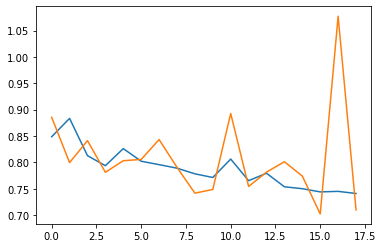

In [14]:
plt.plot(hist_model_DisCo.history['loss'][1:-1])
plt.plot(hist_model_DisCo.history['val_loss'][1:-1])

In [15]:
preds_DisCo = model_DisCo.predict(X_val)

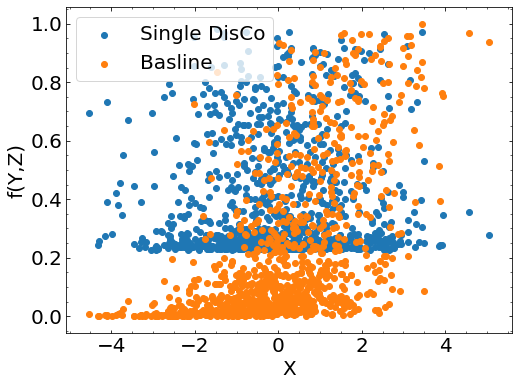

In [16]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

plt.scatter(X_val[Y_val==0][:,0][0:1000],preds_DisCo[Y_val==0][0:1000],label="Single DisCo")
plt.scatter(X_val[Y_val==0][:,0][0:1000],preds_baseline[Y_val==0][0:1000],label="Basline")
plt.xlabel("X",fontsize=20)
plt.ylabel("f(Y,Z)",fontsize=20)
plt.legend(frameon=True,fontsize=20)
plt.savefig("ToyNN_versus_X_singleDisCo.pdf",bbox_inches='tight')

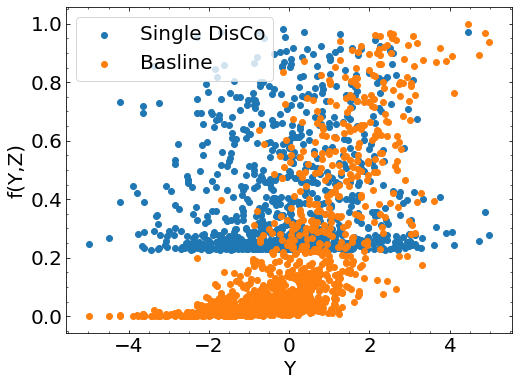

In [17]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

plt.scatter(X_val[Y_val==0][:,1][0:1000],preds_DisCo[Y_val==0][0:1000],label="Single DisCo")
plt.scatter(X_val[Y_val==0][:,1][0:1000],preds_baseline[Y_val==0][0:1000],label="Basline")
plt.xlabel("Y",fontsize=20)
plt.ylabel("f(Y,Z)",fontsize=20)
plt.legend(frameon=True,fontsize=20)
plt.savefig("ToyNN_versus_Y_singleDisCo.pdf",bbox_inches='tight')

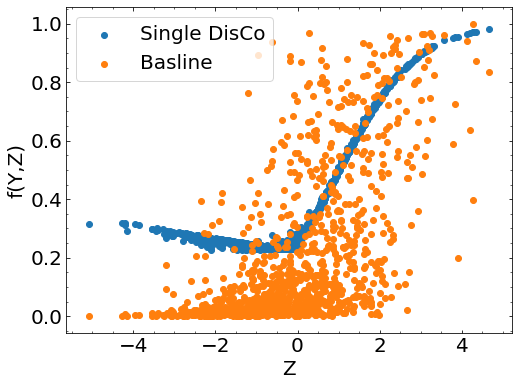

In [18]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

plt.scatter(X_val[Y_val==0][:,2][0:1000],preds_DisCo[Y_val==0][0:1000],label="Single DisCo")
plt.scatter(X_val[Y_val==0][:,2][0:1000],preds_baseline[Y_val==0][0:1000],label="Basline")
plt.xlabel("Z",fontsize=20)
plt.ylabel("f(Y,Z)",fontsize=20)
plt.legend(frameon=True,fontsize=20)
plt.savefig("ToyNN_versus_Z_singleDisCo.pdf",bbox_inches='tight')

In [19]:
DisCo_np(X_val[Y_val==0][:,0][0:10000],preds_DisCo[Y_val==0][0:10000])

0.0004561135466331006

In [20]:
def DoubleDisCo(y_true, y_pred, alpha = 0.):
    #alpha determines the amount of decorrelation; 0 means no decorrelation.
    
    X_in = y_pred[:,0]
    Y_in = y_pred[:,1]

    #Only require decorrelation for the background.
    mymaskX = tf.where(y_true[:,0]<1,K.ones_like(X_in),K.zeros_like(X_in))
    mymaskY = tf.where(y_true[:,0]<1,K.ones_like(Y_in),K.zeros_like(Y_in))
    X = tf.boolean_mask(X_in, mymaskX)
    Y = tf.boolean_mask(Y_in, mymaskY)
    
    LX = K.shape(X)[0]
    LY = K.shape(Y)[0]
    
    X=K.reshape(X,shape=(LX,1))
    Y=K.reshape(Y,shape=(LY,1))    
    
    ajk = K.abs(K.reshape(K.repeat(X,LX),shape=(LX,LX)) - K.transpose(X))
    bjk = K.abs(K.reshape(K.repeat(Y,LY),shape=(LY,LY)) - K.transpose(Y))

    Ajk = ajk - K.mean(ajk,axis=0)[None, :] - K.mean(ajk,axis=1)[:, None] + K.mean(ajk)
    Bjk = bjk - K.mean(bjk,axis=0)[None, :] - K.mean(bjk,axis=1)[:, None] + K.mean(bjk)

    dcor = K.sum(Ajk*Bjk) / K.sqrt(K.sum(Ajk*Ajk)*K.sum(Bjk*Bjk))    
    
    return binary_crossentropy(y_true[:,0],y_pred[:,0]) + binary_crossentropy(y_true[:,0],y_pred[:,1]) + alpha*dcor

In [21]:
model_DoubleDisCo = Sequential()
model_DoubleDisCo.add(Dense(128, activation='relu',input_shape =(3,))) 
model_DoubleDisCo.add(Dense(128, activation='relu')) 
#model_DoubleDisCo.add(layers.Dropout(0.25))
model_DoubleDisCo.add(Dense(128, activation='relu'))
#model_DoubleDisCo.add(layers.Dropout(0.25))
model_DoubleDisCo.add(Dense(2, activation='sigmoid'))
model_DoubleDisCo.compile(loss=lambda y_true, y_pred: DoubleDisCo(y_true, y_pred, alpha = 1000.), optimizer='adam', metrics=['accuracy'])

In [22]:
checkpoint = ModelCheckpoint("/data0/bpnachman/weights/saved-model-{epoch:02d}_v2.hdf5", save_best_only=False, mode='auto', period=1,save_weights_only=True)
hist_model_DoubleDisCo = model_DoubleDisCo.fit(X_train, Y_train, epochs=200, batch_size=int(0.01*len(X_train)),validation_data=(X_val, Y_val), callbacks=[checkpoint])

/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 3400000 samples, validate on 600000 samples
Epoch 1/200
3400000/3400000 [==============================] - 20s 6us/step - loss: 8.6992 - acc: 0.7806 - val_loss: 2.1286 - val_acc: 0.7922
Epoch 2/200
3400000/3400000 [==============================] - 20s 6us/step - loss: 1.9164 - acc: 0.7811 - val_loss: 2.0213 - val_acc: 0.7758
Epoch 3/200
3400000/3400000 [==============================] - 20s 6us/step - loss: 1.8562 - acc: 0.7647 - val_loss: 1.7585 - val_acc: 0.7611
Epoch 4/200
3400000/3400000 [==============================] - 20s 6us/step - loss: 1.8761 - acc: 0.7563 - val_loss: 3.2022 - val_acc: 0.7511
Epoch 5/200
3400000/3400000 [==============================] - 20s 6us/step - loss: 2.2233 - acc: 0.7375 - val_loss: 1.7127 - val_acc: 0.7264
Epoch 6/200
3400000/3400000 [==============================] - 20s 6us/step - loss: 1.8524 - acc: 0.7163 - val_loss: 1.7252 - val_acc: 0.7061
Epoch 7/200
3400000/3400000 [==============================] - 20s 6us/step - loss: 1.8219 - ac

Epoch 58/200
3400000/3400000 [==============================] - 20s 6us/step - loss: 1.1863 - acc: 0.5580 - val_loss: 1.0503 - val_acc: 0.5637
Epoch 59/200
3400000/3400000 [==============================] - 20s 6us/step - loss: 1.2677 - acc: 0.5550 - val_loss: 1.1173 - val_acc: 0.5501
Epoch 60/200
3400000/3400000 [==============================] - 20s 6us/step - loss: 1.1907 - acc: 0.5530 - val_loss: 1.0656 - val_acc: 0.5606
Epoch 61/200
3400000/3400000 [==============================] - 20s 6us/step - loss: 1.2715 - acc: 0.5581 - val_loss: 1.1929 - val_acc: 0.5609
Epoch 62/200
3400000/3400000 [==============================] - 20s 6us/step - loss: 1.4315 - acc: 0.5558 - val_loss: 1.0415 - val_acc: 0.5610
Epoch 63/200
3400000/3400000 [==============================] - 20s 6us/step - loss: 1.1869 - acc: 0.5557 - val_loss: 1.0351 - val_acc: 0.5571
Epoch 64/200
3400000/3400000 [==============================] - 20s 6us/step - loss: 1.1860 - acc: 0.5594 - val_loss: 1.0792 - val_acc: 0.5625

3400000/3400000 [==============================] - 20s 6us/step - loss: 1.0018 - acc: 0.5876 - val_loss: 0.8978 - val_acc: 0.5842
Epoch 116/200
3400000/3400000 [==============================] - 20s 6us/step - loss: 1.0945 - acc: 0.5757 - val_loss: 0.9451 - val_acc: 0.5817
Epoch 117/200
3400000/3400000 [==============================] - 20s 6us/step - loss: 1.0005 - acc: 0.5862 - val_loss: 0.8824 - val_acc: 0.5951
Epoch 118/200
3400000/3400000 [==============================] - 20s 6us/step - loss: 1.0815 - acc: 0.5924 - val_loss: 1.5612 - val_acc: 0.5875
Epoch 119/200
3400000/3400000 [==============================] - 20s 6us/step - loss: 1.0878 - acc: 0.5696 - val_loss: 0.9130 - val_acc: 0.5740
Epoch 120/200
3400000/3400000 [==============================] - 20s 6us/step - loss: 1.0298 - acc: 0.5817 - val_loss: 1.6496 - val_acc: 0.5896
Epoch 121/200
3400000/3400000 [==============================] - 19s 6us/step - loss: 1.0913 - acc: 0.5837 - val_loss: 0.8831 - val_acc: 0.5821
Epoch 

Epoch 172/200
3400000/3400000 [==============================] - 19s 6us/step - loss: 0.9325 - acc: 0.5609 - val_loss: 0.9778 - val_acc: 0.5690
Epoch 173/200
3400000/3400000 [==============================] - 20s 6us/step - loss: 1.0406 - acc: 0.5660 - val_loss: 1.0689 - val_acc: 0.5661
Epoch 174/200
3400000/3400000 [==============================] - 20s 6us/step - loss: 1.0054 - acc: 0.5569 - val_loss: 0.8666 - val_acc: 0.5658
Epoch 175/200
3400000/3400000 [==============================] - 20s 6us/step - loss: 0.9426 - acc: 0.5475 - val_loss: 0.9147 - val_acc: 0.5474
Epoch 176/200
3400000/3400000 [==============================] - 20s 6us/step - loss: 0.9682 - acc: 0.5558 - val_loss: 0.8648 - val_acc: 0.5894
Epoch 177/200
3400000/3400000 [==============================] - 20s 6us/step - loss: 1.1256 - acc: 0.5847 - val_loss: 0.8864 - val_acc: 0.5776
Epoch 178/200
3400000/3400000 [==============================] - 20s 6us/step - loss: 1.0089 - acc: 0.5654 - val_loss: 1.5078 - val_acc:

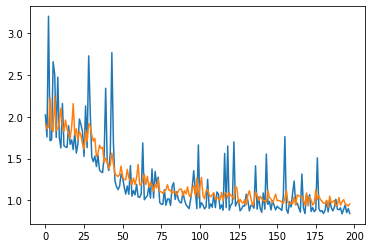

In [23]:
plt.plot(hist_model_DoubleDisCo.history['val_loss'][1:-1])
plt.plot(hist_model_DoubleDisCo.history['loss'][1:-1])

In [24]:
preds_DD = model_DoubleDisCo.predict(X_val)
fpr_DD0, tpr_DD0, _ = roc_curve(Y_val, preds_DD[:,0])
fpr_DD1, tpr_DD1, _ = roc_curve(Y_val, preds_DD[:,1])

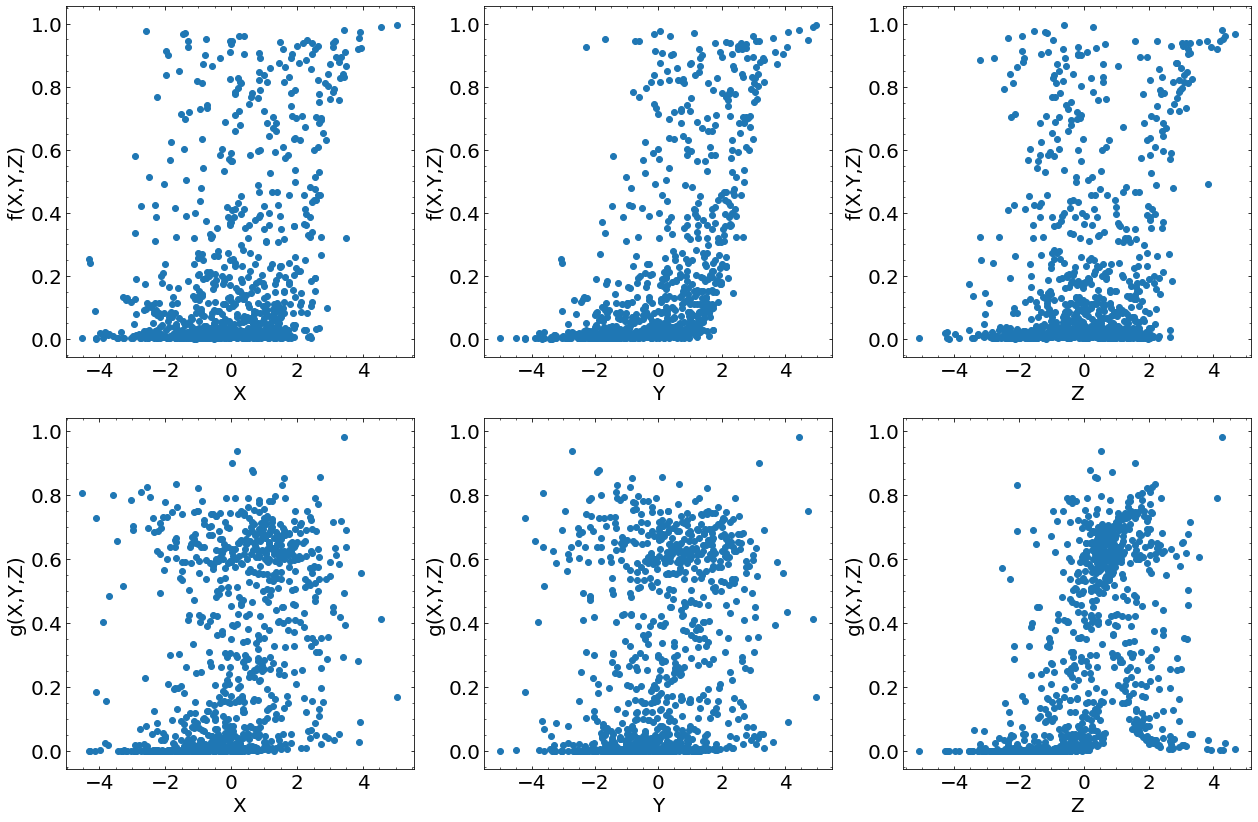

In [25]:
figure, axes = plt.subplots(figsize=(18, 12),nrows=2, ncols=3)
figure.tight_layout(pad=4.0)

ax0 = plt.subplot(231)
plt.scatter(X_val[Y_val==0][:,0][0:1000],preds_DD[Y_val==0][0:1000][:,0])
plt.xlabel("X",fontsize=20)
plt.ylabel("f(X,Y,Z)",fontsize=20)
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

ax0 = plt.subplot(232)
plt.scatter(X_val[Y_val==0][:,1][0:1000],preds_DD[Y_val==0][0:1000][:,0])
plt.xlabel("Y",fontsize=20)
plt.ylabel("f(X,Y,Z)",fontsize=20)
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

ax0 = plt.subplot(233)
plt.scatter(X_val[Y_val==0][:,2][0:1000],preds_DD[Y_val==0][0:1000][:,0])
plt.xlabel("Z",fontsize=20)
plt.ylabel("f(X,Y,Z)",fontsize=20)
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

ax0 = plt.subplot(234)
plt.scatter(X_val[Y_val==0][:,0][0:1000],preds_DD[Y_val==0][0:1000][:,1])
plt.xlabel("X",fontsize=20)
plt.ylabel("g(X,Y,Z)",fontsize=20)
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

ax0 = plt.subplot(235)
plt.scatter(X_val[Y_val==0][:,1][0:1000],preds_DD[Y_val==0][0:1000][:,1])
plt.xlabel("Y",fontsize=20)
plt.ylabel("g(X,Y,Z)",fontsize=20)
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

ax0 = plt.subplot(236)
plt.scatter(X_val[Y_val==0][:,2][0:1000],preds_DD[Y_val==0][0:1000][:,1])
plt.xlabel("Z",fontsize=20)
plt.ylabel("g(X,Y,Z)",fontsize=20)
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

plt.savefig("ToyNN_DDplots.pdf",bbox_inches='tight')

In [26]:
preds_DDs = {}

In [27]:
for i in range(1,201):
    print(i)
    if (i < 10):
        model_DoubleDisCo.load_weights("/data0/bpnachman/weights/saved-model-0"+str(i)+"_v2.hdf5")
    else:
        model_DoubleDisCo.load_weights("/data0/bpnachman/weights/saved-model-"+str(i)+"_v2.hdf5")
        #model_DoubleDisCo.load_weights("weights/saved-model-"+str(i)+".hdf5")
    preds_DDs[i] = model_DoubleDisCo.predict(X_val,batch_size=int(0.01*len(X_val)))
    pass

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200


In [28]:
'''
#for i in preds_DDs:
for i in range(1,201):
    figure, axes = plt.subplots(figsize=(18, 12),nrows=2, ncols=3)
    figure.tight_layout(pad=4.0)

    ax0 = plt.subplot(231)
    plt.scatter(X_val[Y_val==0][:,0][0:1000],preds_DDs[i][Y_val==0][0:1000][:,0])
    plt.xlabel("X",fontsize=20)
    plt.ylabel("f(X,Y,Z), "+str(i),fontsize=20)
    ax0.yaxis.set_ticks_position('both')
    ax0.xaxis.set_ticks_position('both')
    ax0.tick_params(direction="in",which="both")
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    ax0.minorticks_on()

    ax0 = plt.subplot(232)
    plt.scatter(X_val[Y_val==0][:,1][0:1000],preds_DDs[i][Y_val==0][0:1000][:,0])
    plt.xlabel("Y",fontsize=20)
    plt.ylabel("f(X,Y,Z), "+str(i),fontsize=20)
    ax0.yaxis.set_ticks_position('both')
    ax0.xaxis.set_ticks_position('both')
    ax0.tick_params(direction="in",which="both")
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    ax0.minorticks_on()

    ax0 = plt.subplot(233)
    plt.scatter(X_val[Y_val==0][:,2][0:1000],preds_DDs[i][Y_val==0][0:1000][:,0])
    plt.xlabel("Z",fontsize=20)
    plt.ylabel("f(X,Y,Z), "+str(i),fontsize=20)
    ax0.yaxis.set_ticks_position('both')
    ax0.xaxis.set_ticks_position('both')
    ax0.tick_params(direction="in",which="both")
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    ax0.minorticks_on()

    ax0 = plt.subplot(234)
    plt.scatter(X_val[Y_val==0][:,0][0:1000],preds_DDs[i][Y_val==0][0:1000][:,1])
    plt.xlabel("X",fontsize=20)
    plt.ylabel("g(X,Y,Z), "+str(i),fontsize=20)
    ax0.yaxis.set_ticks_position('both')
    ax0.xaxis.set_ticks_position('both')
    ax0.tick_params(direction="in",which="both")
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    ax0.minorticks_on()

    ax0 = plt.subplot(235)
    plt.scatter(X_val[Y_val==0][:,1][0:1000],preds_DDs[i][Y_val==0][0:1000][:,1])
    plt.xlabel("Y",fontsize=20)
    plt.ylabel("g(X,Y,Z), "+str(i),fontsize=20)
    ax0.yaxis.set_ticks_position('both')
    ax0.xaxis.set_ticks_position('both')
    ax0.tick_params(direction="in",which="both")
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    ax0.minorticks_on()

    ax0 = plt.subplot(236)
    plt.scatter(X_val[Y_val==0][:,2][0:1000],preds_DDs[i][Y_val==0][0:1000][:,1])
    plt.xlabel("Z",fontsize=20)
    plt.ylabel("g(X,Y,Z), "+str(i),fontsize=20)
    ax0.yaxis.set_ticks_position('both')
    ax0.xaxis.set_ticks_position('both')
    ax0.tick_params(direction="in",which="both")
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    ax0.minorticks_on()
'''

'\n#for i in preds_DDs:\nfor i in range(1,201):\n    figure, axes = plt.subplots(figsize=(18, 12),nrows=2, ncols=3)\n    figure.tight_layout(pad=4.0)\n\n    ax0 = plt.subplot(231)\n    plt.scatter(X_val[Y_val==0][:,0][0:1000],preds_DDs[i][Y_val==0][0:1000][:,0])\n    plt.xlabel("X",fontsize=20)\n    plt.ylabel("f(X,Y,Z), "+str(i),fontsize=20)\n    ax0.yaxis.set_ticks_position(\'both\')\n    ax0.xaxis.set_ticks_position(\'both\')\n    ax0.tick_params(direction="in",which="both")\n    plt.xticks(fontsize=20)\n    plt.yticks(fontsize=20)\n    ax0.minorticks_on()\n\n    ax0 = plt.subplot(232)\n    plt.scatter(X_val[Y_val==0][:,1][0:1000],preds_DDs[i][Y_val==0][0:1000][:,0])\n    plt.xlabel("Y",fontsize=20)\n    plt.ylabel("f(X,Y,Z), "+str(i),fontsize=20)\n    ax0.yaxis.set_ticks_position(\'both\')\n    ax0.xaxis.set_ticks_position(\'both\')\n    ax0.tick_params(direction="in",which="both")\n    plt.xticks(fontsize=20)\n    plt.yticks(fontsize=20)\n    ax0.minorticks_on()\n\n    ax0 = plt.s

In [29]:
epos = []
disco12 = []
disco13 = []
disco23 = []
disco1f = []
disco2f = []
disco3f = []
disco1g = []
disco2g = []
disco3g = []
discofg = []
for i in preds_DDs:
    print(i)
    disco12+=[DisCo_np(X_val[Y_val==0][:,0][0:1000],X_val[Y_val==0][:,1][0:1000])]
    disco13+=[DisCo_np(X_val[Y_val==0][:,0][0:1000],X_val[Y_val==0][:,2][0:1000])]
    disco23+=[DisCo_np(X_val[Y_val==0][:,1][0:1000],X_val[Y_val==0][:,2][0:1000])]
    disco1f+=[DisCo_np(X_val[Y_val==0][:,0][0:1000],preds_DDs[i][Y_val==0][0:1000][:,0])]
    disco2f+=[DisCo_np(X_val[Y_val==0][:,1][0:1000],preds_DDs[i][Y_val==0][0:1000][:,0])]
    disco3f+=[DisCo_np(X_val[Y_val==0][:,2][0:1000],preds_DDs[i][Y_val==0][0:1000][:,0])]
    disco1g+=[DisCo_np(X_val[Y_val==0][:,0][0:1000],preds_DDs[i][Y_val==0][0:1000][:,1])]
    disco2g+=[DisCo_np(X_val[Y_val==0][:,1][0:1000],preds_DDs[i][Y_val==0][0:1000][:,1])]
    disco3g+=[DisCo_np(X_val[Y_val==0][:,2][0:1000],preds_DDs[i][Y_val==0][0:1000][:,1])] 
    discofg+=[DisCo_np(preds_DDs[i][Y_val==0][0:1000][:,0],preds_DDs[i][Y_val==0][0:1000][:,1])] 
    pass

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200


(0, 0.5)

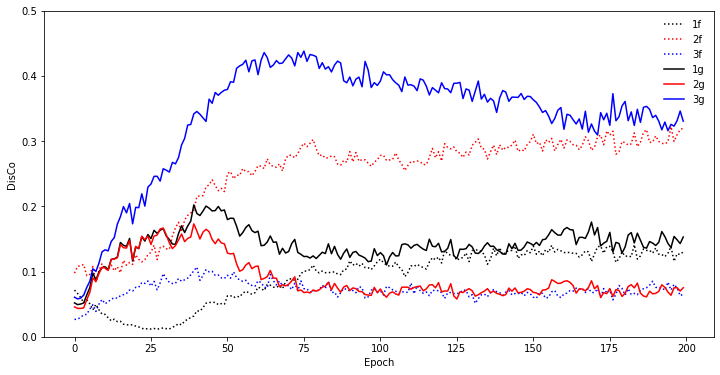

In [30]:
fig = plt.figure(figsize=(12, 6))
plt.plot(range(len(disco12)),disco1f,label="1f",ls=":",color="black")
plt.plot(range(len(disco12)),disco2f,label="2f",ls=":",color="red")
plt.plot(range(len(disco12)),disco3f,label="3f",ls=":",color="blue")
plt.plot(range(len(disco12)),disco1g,label="1g",color="black")
plt.plot(range(len(disco12)),disco2g,label="2g",color="red")
plt.plot(range(len(disco12)),disco3g,label="3g",color="blue")
#plt.plot(range(len(disco12)),discofg,label="fg")
plt.legend(frameon=False)
plt.ylabel("DisCo")
plt.xlabel("Epoch")
plt.ylim([0,0.5])

Text(0.5, 0, 'Epoch')

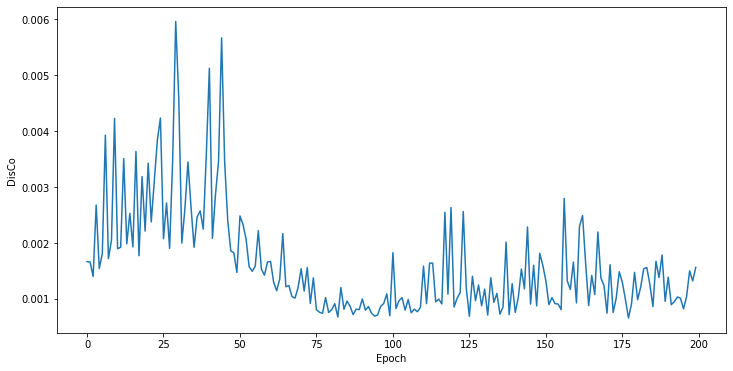

In [31]:
fig = plt.figure(figsize=(12, 6))
plt.plot(range(len(disco12)),discofg,label="fg")
plt.ylabel("DisCo")
plt.xlabel("Epoch")
#plt.plot(hist_model_DoubleDisCo.history['val_loss'][1:-1])
#plt.plot(hist_model_DoubleDisCo.history['loss'][1:-1])

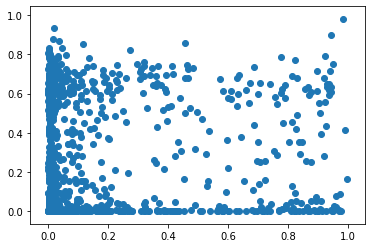

In [32]:
plt.scatter(preds_DD[Y_val==0][0:1000][:,0],preds_DD[Y_val==0][0:1000][:,1])

In [33]:
DisCo_np(preds_DD[Y_val==0][:,0][0:10000],preds_DD[Y_val==0][:,1][0:10000])

0.00015130622

In [34]:
model_all = Sequential()
model_all.add(Dense(128, activation='relu',input_shape =(3,))) 
model_all.add(Dense(128, activation='relu'))
model_all.add(Dense(128, activation='relu'))
model_all.add(Dense(1, activation='sigmoid'))
model_all.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])
hist_model_all = model_all.fit(X_train, Y_train, epochs=10, batch_size=int(0.01*len(X_train)),validation_data=(X_val, Y_val))

Train on 3400000 samples, validate on 600000 samples
Epoch 1/10
3400000/3400000 [==============================] - 3s 1us/step - loss: 0.3056 - acc: 0.8587 - val_loss: 0.2289 - val_acc: 0.9036
Epoch 2/10
3400000/3400000 [==============================] - 2s 1us/step - loss: 0.2286 - acc: 0.9037 - val_loss: 0.2271 - val_acc: 0.9042
Epoch 3/10
3400000/3400000 [==============================] - 2s 1us/step - loss: 0.2277 - acc: 0.9039 - val_loss: 0.2266 - val_acc: 0.9044
Epoch 4/10
3400000/3400000 [==============================] - 2s 1us/step - loss: 0.2273 - acc: 0.9040 - val_loss: 0.2264 - val_acc: 0.9045
Epoch 5/10
3400000/3400000 [==============================] - 2s 1us/step - loss: 0.2273 - acc: 0.9040 - val_loss: 0.2263 - val_acc: 0.9046
Epoch 6/10
3400000/3400000 [==============================] - 2s 1us/step - loss: 0.2272 - acc: 0.9040 - val_loss: 0.2264 - val_acc: 0.9046
Epoch 7/10
3400000/3400000 [==============================] - 2s 1us/step - loss: 0.2270 - acc: 0.9041 - va

In [35]:
preds_A = model_all.predict(X_val)
fpr_A, tpr_A, _ = roc_curve(Y_val, preds_A)

In [36]:
model_M = Sequential()
model_M.add(Dense(128, activation='relu',input_shape =(1,))) 
model_M.add(Dense(128, activation='relu'))
model_M.add(Dense(128, activation='relu'))
model_M.add(Dense(1, activation='sigmoid'))
model_M.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])
hist_model_M = model_M.fit(X_train[:,0], Y_train, epochs=10, batch_size=int(0.01*len(X_train)),validation_data=(X_val[:,0], Y_val))

Train on 3400000 samples, validate on 600000 samples
Epoch 1/10
3400000/3400000 [==============================] - 2s 1us/step - loss: 0.4603 - acc: 0.7804 - val_loss: 0.4328 - val_acc: 0.7982
Epoch 2/10
3400000/3400000 [==============================] - 2s 1us/step - loss: 0.4332 - acc: 0.7975 - val_loss: 0.4327 - val_acc: 0.7982
Epoch 3/10
3400000/3400000 [==============================] - 2s 1us/step - loss: 0.4332 - acc: 0.7975 - val_loss: 0.4326 - val_acc: 0.7981
Epoch 4/10
3400000/3400000 [==============================] - 2s 1us/step - loss: 0.4331 - acc: 0.7975 - val_loss: 0.4326 - val_acc: 0.7982
Epoch 5/10
3400000/3400000 [==============================] - 2s 1us/step - loss: 0.4331 - acc: 0.7975 - val_loss: 0.4326 - val_acc: 0.7982
Epoch 6/10
3400000/3400000 [==============================] - 2s 1us/step - loss: 0.4332 - acc: 0.7974 - val_loss: 0.4326 - val_acc: 0.7981
Epoch 7/10
3400000/3400000 [==============================] - 2s 1us/step - loss: 0.4331 - acc: 0.7975 - va

In [37]:
preds_M = model_M.predict(X_val[:,0])

In [38]:
preds_D = preds_DisCo

In [39]:
fpr_D, tpr_D, _ = roc_curve(Y_val, preds_DisCo[:,0])
fpr_M, tpr_M, _ = roc_curve(Y_val, preds_M)

/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


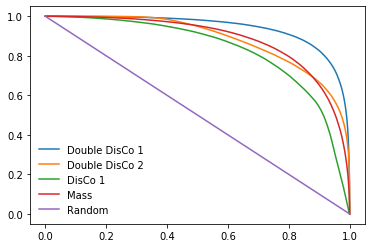

In [40]:
plt.plot(tpr_DD0,1-fpr_DD0,label="Double DisCo 1")
plt.plot(tpr_DD1,1-fpr_DD1,label="Double DisCo 2")
plt.plot(tpr_D,1-fpr_D,label="DisCo 1")
plt.plot(tpr_M,1-fpr_M,label="Mass")
plt.plot(tpr_DD0,1-tpr_DD0,label="Random")
plt.legend(frameon=False)

/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


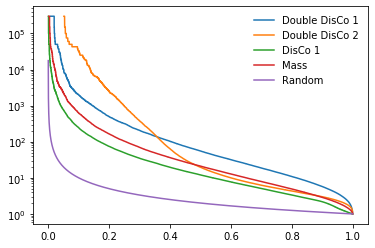

In [41]:
plt.plot(tpr_DD0,1./fpr_DD0,label="Double DisCo 1")
plt.plot(tpr_DD1,1./fpr_DD1,label="Double DisCo 2")
plt.plot(tpr_D,1./fpr_D,label="DisCo 1")
plt.plot(tpr_M,1./fpr_M,label="Mass")
plt.plot(tpr_DD0,1./tpr_DD0,label="Random")
plt.yscale("log")
plt.legend(frameon=False)

In [42]:
#Let's make a list of cut values.
Nscan = 10
ll = int(1.*len(preds_DD[:,0])/Nscan)
scanvals = [np.sort(preds_DD[:,0])[ll*i] for i in range(Nscan)]

ll2 = int(1.*len(preds_DD[:,1])/Nscan)
scanvals2 = [np.sort(preds_DD[:,1])[ll*i] for i in range(Nscan)]

ll_D = int(1.*len(preds_D[:,0])/Nscan)
scanvals_D = [np.sort(preds_D[:,0])[ll*i] for i in range(Nscan)]

ll_M = int(1.*len(preds_M[:,0])/Nscan)
scanvals_M = [np.sort(preds_M[:,0])[ll*i] for i in range(Nscan)]

In [43]:
tprs = []
fprs = []
ABCD_S = []
ABCD_closure = []
for ix in range(len(scanvals)):
    x = scanvals[ix]
    print(x)
    for iy in range(len(scanvals2)):
        y = scanvals2[iy]
        S = sum((preds_DD[Y_val==1][:,0]>x)*(preds_DD[Y_val==1][:,1]>y))/len(preds_DD[Y_val==1])
        B = sum((preds_DD[Y_val==0][:,0]>x)*(preds_DD[Y_val==0][:,1]>y))/len(preds_DD[Y_val==0])
        
        tprs+=[S]
        fprs+=[B]
        
        B11 = sum((preds_DD[Y_val==0][:,0]>x)*(preds_DD[Y_val==0][:,1]>y))
        B01 = sum((preds_DD[Y_val==0][:,0]<=x)*(preds_DD[Y_val==0][:,1]>y))
        B10 = sum((preds_DD[Y_val==0][:,0]>x)*(preds_DD[Y_val==0][:,1]<=y))
        B00 = sum((preds_DD[Y_val==0][:,0]<=x)*(preds_DD[Y_val==0][:,1]<=y))
        
        ABCD_S += [S]
        ABCD_closure += [(B01*B10/B00)/B11]
        
        pass
    pass

0.00021470341


/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in long_scalars


0.0070865173
0.017813213
0.06870386
0.2524775
0.5658605
0.81249315
0.92206156
0.96295077
0.98373955


In [44]:
tprs2 = []
fprs2 = []
ABCD2_S = []
ABCD2_closure = []
for ix in range(len(scanvals_D)):
    x = scanvals_D[ix]
    print(x)
    for iy in range(len(scanvals_M)):
        y = scanvals_M[iy]
        S = sum((preds_D[Y_val==1]>x)*(preds_M[Y_val==1]>y))/len(preds_D[Y_val==1])
        B = sum((preds_D[Y_val==0]>x)*(preds_M[Y_val==0]>y))/len(preds_D[Y_val==0])
        tprs2+=[S]
        fprs2+=[B]

        B11 = sum((preds_D[Y_val==0]>x)*(preds_M[Y_val==0]>y))
        B01 = sum((preds_D[Y_val==0]<=x)*(preds_M[Y_val==0]>y))
        B10 = sum((preds_D[Y_val==0]>x)*(preds_M[Y_val==0]<=y))
        B00 = sum((preds_D[Y_val==0]<=x)*(preds_M[Y_val==0]<=y))
        
        ABCD2_S += [S]
        ABCD2_closure += [(B01*B10/B00)/B11]

        pass
    pass

0.22614573


/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide


0.23720804
0.25169253
0.28117985
0.37677297
0.5048999
0.6326695
0.74900055
0.8470402
0.92700785


In [45]:
tprs = np.array(tprs)
fprs = np.array(fprs)

tprs2 = np.array(tprs2)
fprs2 = np.array(fprs2)

/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


Text(0, 0.5, '1 / False Positive')

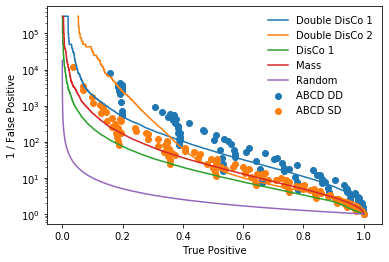

In [46]:
plt.plot(tpr_DD0,1./fpr_DD0,label="Double DisCo 1")
plt.plot(tpr_DD1,1./fpr_DD1,label="Double DisCo 2")
plt.plot(tpr_D,1./fpr_D,label="DisCo 1")
plt.plot(tpr_M,1./fpr_M,label="Mass")
plt.plot(tpr_DD0,1./tpr_DD0,label="Random")
plt.scatter(tprs,1./fprs,label="ABCD DD")
plt.scatter(tprs2,1./fprs2,label="ABCD SD")
plt.legend(frameon=False)
plt.yscale("log")
plt.xlabel("True Positive")
plt.ylabel("1 / False Positive")

In [47]:
#Make a David-style plot that shows the a distribution of R10?

In [48]:
print(DisCo_np(preds_DD[Y_val==0][:,0][0:10000],preds_DD[Y_val==0][:,1][0:10000]))
print(DisCo_np(X_val[Y_val==0][:,0][0:10000],preds_D[Y_val==0][0:10000]))
print(DisCo_np(preds_M[Y_val==0][:,0][0:10000],preds_D[Y_val==0][0:10000]))

0.00015130622
0.0004561135466331006
0.00034781708


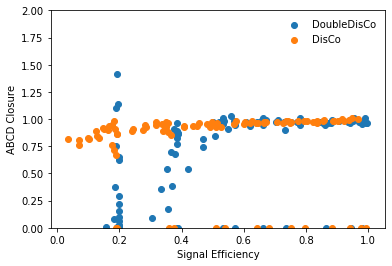

In [49]:
plt.scatter(ABCD_S,ABCD_closure,label="DoubleDisCo")
plt.scatter(ABCD2_S,ABCD2_closure,label="DisCo")
plt.xlabel("Signal Efficiency")
plt.ylabel("ABCD Closure")
plt.ylim(0,2)
plt.legend(frameon=False)

In [50]:
#Let's try again, now where we scan over fixed signal efficiencies.

In [51]:
sigeffics = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.75,0.8,0.85,0.9,0.95]
myepsilon = 0.001

eps_s = {}
eps_b = {}
closure = {}
contamination = {}

Seps_s = {}
Seps_b = {}
Sclosure = {}
Scontamination = {}

for sigeffic in sigeffics:

    eps_s[sigeffic] = []
    eps_b[sigeffic] = []
    closure[sigeffic] = []
    contamination[sigeffic] = []

    Seps_s[sigeffic] = []
    Seps_b[sigeffic] = []
    Sclosure[sigeffic] = []
    Scontamination[sigeffic] = []

    mycounter = 0
    for myeffics in np.linspace(sigeffic,0.99,100):
        mycounter+=1
        if (mycounter%10==0):
            print(mycounter)
            pass
        cut1 = np.quantile(preds_DD[Y_val==1][:,1],1.-myeffics)
        cut2 = np.quantile(preds_DD[(Y_val==1) & (preds_DD[:,1] > cut1)][:,0],1.-sigeffic/myeffics)
        num = len(preds_DD[(Y_val==1) & (preds_DD[:,1] > cut1) & (preds_DD[:,0] > cut2)])
        den = len(preds_DD[(Y_val==1)])

        numB = len(preds_DD[(Y_val==0) & (preds_DD[:,1] > cut1) & (preds_DD[:,0] > cut2)])
        denB = len(preds_DD[(Y_val==0)])    

        A = myepsilon+len(preds_DD[(Y_val==0) & (preds_DD[:,1] > cut1) & (preds_DD[:,0] < cut2)])
        B = myepsilon+len(preds_DD[(Y_val==0) & (preds_DD[:,1] > cut1) & (preds_DD[:,0] > cut2)])
        C = myepsilon+len(preds_DD[(Y_val==0) & (preds_DD[:,1] < cut1) & (preds_DD[:,0] < cut2)])
        D = myepsilon+len(preds_DD[(Y_val==0) & (preds_DD[:,1] < cut1) & (preds_DD[:,0] > cut2)])

        As = myepsilon+len(preds_DD[(Y_val==1) & (preds_DD[:,1] > cut1) & (preds_DD[:,0] < cut2)])
        Bs = myepsilon+len(preds_DD[(Y_val==1) & (preds_DD[:,1] > cut1) & (preds_DD[:,0] > cut2)])
        Cs = myepsilon+len(preds_DD[(Y_val==1) & (preds_DD[:,1] < cut1) & (preds_DD[:,0] < cut2)])
        Ds = myepsilon+len(preds_DD[(Y_val==1) & (preds_DD[:,1] < cut1) & (preds_DD[:,0] > cut2)])    

        eps_s[sigeffic] += [num/den]
        eps_b[sigeffic] += [numB/denB]
        closure[sigeffic] += [(D*A/C)/B]
        contamination[sigeffic] += [(B/Bs) * ((As/A) + (Ds/D) - (Cs/C))]

        #Single DisCo

        cut1 = np.quantile(preds_D[Y_val==1][:,0],1.-myeffics)
        cut2 = np.quantile(preds_M[(Y_val==1) & (preds_D[:,0] > cut1)][:,0],1.-sigeffic/myeffics)
        num = len(preds_DD[(Y_val==1) & (preds_D[:,0] > cut1) & (preds_M[:,0] > cut2)])
        den = len(preds_DD[(Y_val==1)])

        numB = len(preds_DD[(Y_val==0) & (preds_D[:,0] > cut1) & (preds_M[:,0] > cut2)])
        denB = len(preds_DD[(Y_val==0)])    

        A = myepsilon+len(preds_DD[(Y_val==0) & (preds_D[:,0] > cut1) & (preds_M[:,0] < cut2)])
        B = myepsilon+len(preds_DD[(Y_val==0) & (preds_D[:,0] > cut1) & (preds_M[:,0] > cut2)])
        C = myepsilon+len(preds_DD[(Y_val==0) & (preds_D[:,0] < cut1) & (preds_M[:,0] < cut2)])
        D = myepsilon+len(preds_DD[(Y_val==0) & (preds_D[:,0] < cut1) & (preds_M[:,0] > cut2)])

        As = myepsilon+len(preds_DD[(Y_val==1) & (preds_D[:,0] > cut1) & (preds_M[:,0] < cut2)])
        Bs = myepsilon+len(preds_DD[(Y_val==1) & (preds_D[:,0] > cut1) & (preds_M[:,0] > cut2)])
        Cs = myepsilon+len(preds_DD[(Y_val==1) & (preds_D[:,0] < cut1) & (preds_M[:,0] < cut2)])
        Ds = myepsilon+len(preds_DD[(Y_val==1) & (preds_D[:,0] < cut1) & (preds_M[:,0] > cut2)])    

        Seps_s[sigeffic] += [num/den]
        Seps_b[sigeffic] += [numB/denB]
        Sclosure[sigeffic] += [(D*A/C)/B]
        Scontamination[sigeffic] += [(B/Bs) * ((As/A) + (Ds/D) - (Cs/C))]    

        #print(myeffics,num/den)
    eps_s[sigeffic] = np.array(eps_s[sigeffic])
    eps_b[sigeffic] = np.array(eps_b[sigeffic])
    closure[sigeffic] = np.array(closure[sigeffic])
    contamination[sigeffic] = np.array(contamination[sigeffic])

    Seps_s[sigeffic] = np.array(Seps_s[sigeffic])
    Seps_b[sigeffic] = np.array(Seps_b[sigeffic])
    Sclosure[sigeffic] = np.array(Sclosure[sigeffic])
    Scontamination[sigeffic] = np.array(Scontamination[sigeffic])
    pass

10
20
30
40
50
60
70
80
90
100
10
20
30
40
50
60
70
80
90
100
10
20
30
40
50
60
70
80
90
100
10
20
30
40
50
60
70
80
90
100
10
20
30
40
50
60
70
80
90
100
10
20
30
40
50
60
70
80
90
100
10
20
30
40
50
60
70
80
90
100
10
20
30
40
50
60
70
80
90
100
10
20
30
40
50
60
70
80
90
100
10
20
30
40
50
60
70
80
90
100
10
20
30
40
50
60
70
80
90
100
10
20
30
40
50
60
70
80
90
100
10
20
30
40
50
60
70
80
90
100
10
20
30
40
50
60
70
80
90
100
10
20
30
40
50
60
70
80
90
100
10
20
30
40
50
60
70
80
90
100
10
20
30
40
50
60
70
80
90
100
10
20
30
40
50
60
70
80
90
100
10
20
30
40
50
60
70
80
90
100
10
20
30
40
50
60
70
80
90
100
10
20
30
40
50
60
70
80
90
100


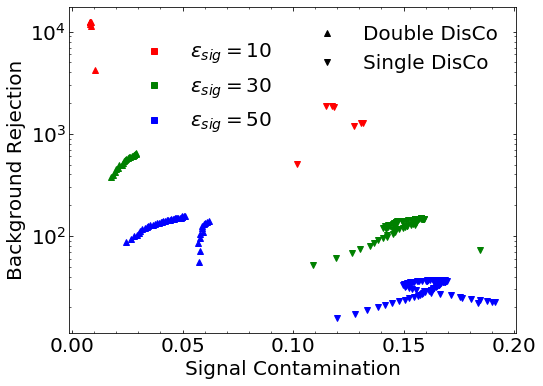

In [52]:
mycolor = {}
mycolor[0.1] = 'red'
mycolor[0.3] = 'green'
mycolor[0.5] = 'blue'

fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

for r in [0.1,0.3,0.5]:
    xx = contamination[r][abs(closure[r]-1.) < 0.1]
    yy = 1./eps_b[r][abs(closure[r]-1.) < 0.1]

    xx2 = Scontamination[r][abs(Sclosure[r]-1.) < 0.1]
    yy2 = 1./Seps_b[r][abs(Sclosure[r]-1.) < 0.1]

    plt.plot(xx,yy,marker='^',ls="none",label=r"Double DisCo, $\epsilon_{sig}=$"+str(r),color=mycolor[r])
    plt.plot(xx2,yy2,marker='v',ls="none",label="Single DisCo, $\epsilon_{sig}=$"+str(r),color=mycolor[r])

plt.xlabel("Signal Contamination",fontsize=20)
plt.ylabel("Background Rejection",fontsize=20)
plt.locator_params(axis='x', nbins=6)
plt.legend(frameon=False,fontsize=12)
plt.yscale("log")

from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='black', lw=0, marker="^",label=r'Double DisCo'),
                   Line2D([0], [0], color='black', lw=0, marker="v",label=r'Single DisCo')]
l1 = ax0.legend(frameon=False,fontsize=20,handles=legend_elements, loc='upper right')
plt.gca().add_artist(l1)

legend_elements = [Line2D([0], [0], color='red', lw=0, marker="s",label=r'$\epsilon_{sig} = 10%$'),
                   Line2D([0], [0], color='green', lw=0, marker="s",label=r'$\epsilon_{sig} = 30%$'),
                   Line2D([0], [0], color='blue', lw=0, marker="s",label=r'$\epsilon_{sig} = 50%$')]
ax0.legend(frameon=False,fontsize=20,handles=legend_elements, loc='upper center',bbox_to_anchor=(0.3,0.95))
#plt.savefig("ToyNN_signal_contamination.pdf",bbox_inches='tight')

In [53]:
#ROC curve

sigeffics = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.75,0.8,0.85,0.9,0.95]
xx = []
yy = []

xx2 = []
yy2 = []

for r in sigeffics:
    xx_hold = eps_s[r][abs(closure[r]-1.) < 0.1]
    yy_hold = eps_b[r][abs(closure[r]-1.) < 0.1]
    whichmax = np.argmin(yy_hold)
    xx+=[xx_hold[whichmax]]
    yy+=[yy_hold[whichmax]]
    
    xx_hold = Seps_s[r][abs(Sclosure[r]-1.) < 0.1]
    yy_hold = Seps_b[r][abs(Sclosure[r]-1.) < 0.1]
    whichmax = np.argmin(yy_hold)
    xx2+=[xx_hold[whichmax]]
    yy2+=[yy_hold[whichmax]]    
    pass
xx = np.array(xx)
yy = np.array(yy)

xx2 = np.array(xx2)
yy2 = np.array(yy2)

/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':
/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  
/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide


Text(0, 0.5, 'Background Rejection')

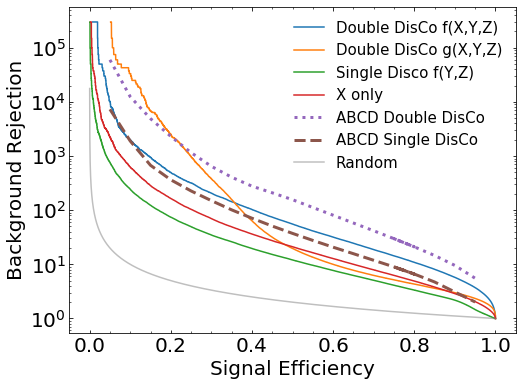

In [54]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

plt.plot(tpr_DD0,1./fpr_DD0,label="Double DisCo f(X,Y,Z)")
plt.plot(tpr_DD1,1./fpr_DD1,label="Double DisCo g(X,Y,Z)")
plt.plot(tpr_D,1./fpr_D,label="Single Disco f(Y,Z)")
plt.plot(tpr_M,1./fpr_M,label="X only")
#plt.scatter(tprs,1./fprs,label="ABCD DD")
#plt.scatter(tprs2,1./fprs2,label="ABCD SD")
plt.plot(xx,1./yy,ls=":",label="ABCD Double DisCo",linewidth=3)
plt.plot(xx2,1./yy2,ls="--",label="ABCD Single DisCo",linewidth=3)
plt.plot(tpr_DD0,1./tpr_DD0,label="Random",color='gray',alpha=0.5)
plt.legend(frameon=False,fontsize=15)
plt.yscale("log")
plt.xlabel("Signal Efficiency",fontsize=20)
plt.ylabel("Background Rejection",fontsize=20)
#plt.savefig("ToyNN_ROC.pdf",bbox_inches='tight')